## Mini Machine Learning Project

### Project Goals
The focus of this project is to be able to assess whether a yelp review is postive or negative based on sentiment analysis of the text. I did some data cleaning such as removing common stop words. I then trained a SVM to predict the sentiment of the review. I assessed the accuracy by predefining positive reviews as having 4 or 5 stars and everything else was considered as negative. Furthermore I did some analysis on the linearity of the data that can be seen below. The SVM was able to achieve an accuracy of ~80%. 

In [11]:
import numpy as np
import pandas as pd
import os
import re
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import nltk  
from nltk.corpus import stopwords
import heapq
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV


In [2]:
# 10000 Yelp reviews
fp = os.path.join('data', 'yelp.csv')
reviews = pd.read_csv(fp)
copy = reviews.copy()
reviews.head()

,Rating,Review
0,1,"First of all i'm not a big fan of buffet, i tr..."
1,2,Thanks Yelp. I was looking for the words to de...
2,3,Service was so-so. They were receiving a deliv...
3,3,Stamoolis Brothers is one of the Strip Distric...
4,1,I want to give a 2 stars because the service s...


In [3]:
# Classifying 4 and 5 as positive (+1) and 3, 2, and 1 as negative (-1)
reviews['Rating'] = reviews['Rating'].apply(lambda x: 1 if x > 3 else -1)
reviews.head()

,Rating,Review
0,-1,"First of all i'm not a big fan of buffet, i tr..."
1,-1,Thanks Yelp. I was looking for the words to de...
2,-1,Service was so-so. They were receiving a deliv...
3,-1,Stamoolis Brothers is one of the Strip Distric...
4,-1,I want to give a 2 stars because the service s...


In [5]:
# This cleaning part was inspired from 
# https://stackabuse.com/removing-stop-words-from-strings-in-python/
# Step - a : Remove blank rows if any.
reviews['Review'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required 
# as python interprets 'dog' and 'DOG' differently
reviews['Review'] = [entry.lower() for entry in reviews['Review']]
# Step - c : Tokenization : In this each entry in the corpus will be 
# broken into set of words
reviews['Review'] = [word_tokenize(entry) for entry in reviews['Review']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word 
# Stemming/Lemmenting. WordNetLemmatizer requires Pos tags to understand 
# if the word is noun 
# or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(reviews['Review']):
    # Declaring Empty List to store the words that follow the rules 
    # for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is 
    # Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider 
        # only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be
    # stored in 'text_final'
    reviews.loc[index,'final_review'] = str(Final_words)

In [6]:
reviews.head()

,Rating,Review,final_review
0,-1,"[first, of, all, i, 'm, not, a, big, fan, of, ...","['first', 'big', 'fan', 'buffet', 'try', 'get'..."
1,-1,"[thanks, yelp, ., i, was, looking, for, the, w...","['thanks', 'yelp', 'look', 'word', 'describe',..."
2,-1,"[service, was, so-so, ., they, were, receiving...","['service', 'receive', 'delivery', 'might', 'f..."
3,-1,"[stamoolis, brothers, is, one, of, the, strip,...","['stamoolis', 'brother', 'one', 'strip', 'dist..."
4,-1,"[i, want, to, give, a, 2, stars, because, the,...","['want', 'give', 'star', 'service', 'staff', '..."


In [7]:
# Breaking up training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    reviews['final_review'], reviews['Rating'], test_size=0.25)

In [8]:
vect = CountVectorizer(max_features=500)
vect.fit(reviews['final_review'])
X_train_vec = vect.transform(X_train)
X_test_vec = vect.transform(X_test)

In [12]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.LinearSVC()
SVM.fit(X_train_vec,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_vec)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  79.96


In [ ]:
# Finding the best C value
Cs = list(np.arange(1,20,1))
parameters = {'C':Cs}
grid = GridSearchCV(SVM, parameters, cv=3)
grid = grid.fit(X_train_vec,y_train)
grid.best_estimator_

In [22]:
errors = 1 - grid.cv_results_.get('mean_test_score')

In [23]:
# Checking training and validation error
clf = grid.best_estimator_
val_error = 100 - (accuracy_score(clf.predict(X_test_vec), y_test)*100)
train_error = 100 - (accuracy_score(clf.predict(X_train_vec), y_train)*100)
print('Validation Error for C=3 is: ' + str(val_error))
print('Training Error for C=3 is: ' + str(train_error))

Validation Error for C=3 is: 19.439999999999998
Training Error for C=3 is: 16.33333333333333


### Part a Summary
1. When C=3 gave me the best results as seen from above.  
2. When C=3 I got a validation error of 19.36% and for the training error I got 15.95%
3. See directly below for graph  
4. See all above for code

Text(0,0.5,'Error')

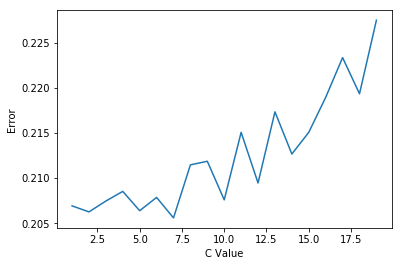

In [24]:
plt.plot(Cs, errors)
plt.xlabel("C Value")
plt.ylabel("Error")

### Part b  
The data is not linearly separable. We know this because our training error was greater than 0. If the data was linearly separable then the SVM would have been able to draw a line that perfectly separates the two classes, thus resulting in 0% error rate.

### Part c
**Sentence that I think is positive that my predictor got right:** 'My favorite Sushi restaurant in Vegas so far.  They have an ALCE option which is usually the best way to go.  **if you order a la carte and  decide to spend more than the $28 AYCE price, they will let you just pay that flat fee and go to town!!! sunrise roll and seared tuna nagiri are my faves!'  

**Sentence that I think is negative that my predictor got right:** "this place is mostly hype.its not like flay is in the kitchen.the food was good,i ordered halibut and it was cooked beautifully.the presentation was pretty and so were the colorful sauce.but the food wasn't that good because it lacked flavor."  
  
**Sentence that I think is positive that my predictor got wrong:** "So why am I a fan?  It's about a block from home, and they are open on Sundays, that's why.  Well not just that, I enjoy the fact that when I have been there it is not too over crowded (unless I need intense socialization I avoid most of these places on First Fridays).   Four Stars for Location, 3 stars for the food. \\nMy friends and I stopped in for lunch on a Sunday.  The prices are fair for the quantity and quality.  My friends Club sandwich looked super yummy and he enjoyed it.  I had the fish and shrimp and another friend had the fish and chips.  Not bad and feed that hungover greasy craving.  The fish and shrimp were crispy and plentiful. \\nI have tried other things there, my favorite still have to be the seasoned waffle fries.  Yum!"

In [100]:
preds = clf.predict(X_test_vec)
indices = X_test.index
test = copy.iloc[indices]
test['Rating'] = reviews['Rating'].apply(lambda x: 1 if x > 3 else -1)
test['Prediction'] = preds
test.head(10)

,Rating,Review,Prediction
626,-1,this place is mostly hype.its not like flay is...,-1
9423,1,My favorite Sushi restaurant in Vegas so far. ...,1
9669,-1,Great for late night IF nothing else is open a...,-1
4760,-1,"Well, I returned to give this place another sh...",-1
7333,-1,Pink's was supposed to be a massive ending to ...,1
4502,-1,"Great atmosphere, fine food, TERRIBLE PRICES.\...",-1
1553,-1,Husband and I went for HH and also ordered som...,-1
2896,-1,After hearing about the eclectic offering at t...,-1
743,-1,Last two times I went to Vegas I came here. Bo...,-1
3572,1,So why am I a fan? It's about a block from ho...,-1


In [104]:
sentence1 = test.iloc[1].values[1]
sentence2 = test.iloc[0].values[1]
sentence3 = test.iloc[9].values[1]